In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

## Loading Images

In [3]:
from tensorflow.keras.preprocessing.image import load_img 

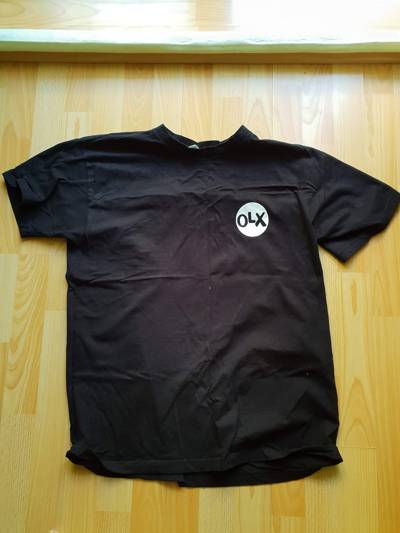

In [4]:
path = '../input/clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

Usually we resize images. This is how a network will see these images:

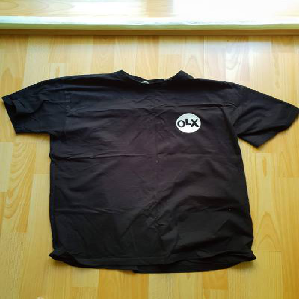

In [5]:
load_img(fullname, target_size=(299, 299))

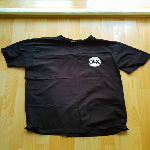

In [6]:
load_img(fullname, target_size=(150, 150))

## Pre-Trained Neural Network

Let's apply a pre-trained neural network with imagenet classes.

We'll use Xception.

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

Next,

* we load the image using the `load_img` function
* convert it to a numpy array
* make it a batch of one example

In [8]:
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
x.shape

(299, 299, 3)

In [9]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

We're ready!

Next, we will:

* prepare the input
* do the predictions
* convert the predictions into a human-readable format

In [10]:
X = preprocess_input(X)

## Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We'll use smaller images - it'll be faster

In [12]:
image_size = (150, 150)
batch_size = 32

Let's get train data:

In [13]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "../input/clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


And validation:

In [14]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "../input/clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


For fine-tuning, we'll use `Xception` with small images (150x150)

In [15]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

2021-12-12 06:28:50.987677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 06:28:51.084980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 06:28:51.086029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 06:28:51.088588: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 3s 0us/step


Let's add a small neural net on top of that: just one layer with 10 neurons (there are 10 classes we want to predict)

In [16]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

Now we specify the learning rate and compile the model. After that, it's ready for training

In [17]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Let's train now for 10 epochs:

In [18]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

2021-12-12 06:28:59.861560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-12 06:29:03.173851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


96/96 [==============================] - 33s 252ms/step - loss: 1.3167 - accuracy: 0.6568 - val_loss: 0.8293 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 14s 150ms/step - loss: 0.6025 - accuracy: 0.8188 - val_loss: 0.8861 - val_accuracy: 0.7625
Epoch 3/10
96/96 [==============================] - 15s 154ms/step - loss: 0.3709 - accuracy: 0.8735 - val_loss: 0.9536 - val_accuracy: 0.7859
Epoch 4/10
96/96 [==============================] - 14s 146ms/step - loss: 0.2840 - accuracy: 0.9009 - val_loss: 0.9727 - val_accuracy: 0.7771
Epoch 5/10
96/96 [==============================] - 14s 148ms/step - loss: 0.1643 - accuracy: 0.9394 - val_loss: 0.8617 - val_accuracy: 0.8182
Epoch 6/10
96/96 [==============================] - 14s 142ms/step - loss: 0.1263 - accuracy: 0.9576 - val_loss: 0.8038 - val_accuracy: 0.8270
Epoch 7/10
96/96 [==============================] - 14s 144ms/step - loss: 0.0578 - accuracy: 0.9831 - val_loss: 0.7822 - val_accuracy: 0.8182
Epoch 8/10

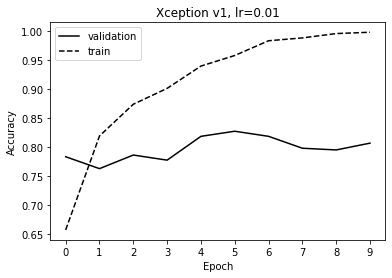

In [19]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

0.01 is not necessarily the best learning rate, so we should experiment with 0.001.

To make it easier for us, let's make a function for defining our model:

In [20]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Watching metrics this way is not convenient, so let's create a special callback for that

In [21]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 17s 156ms/step - loss: 1.1042 - accuracy: 0.6268 - val_loss: 0.7033 - val_accuracy: 0.7889
Epoch 2/10
96/96 [==============================] - 14s 148ms/step - loss: 0.6387 - accuracy: 0.7852 - val_loss: 0.6148 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - 14s 146ms/step - loss: 0.5095 - accuracy: 0.8302 - val_loss: 0.5685 - val_accuracy: 0.8299
Epoch 4/10
96/96 [==============================] - 15s 151ms/step - loss: 0.4277 - accuracy: 0.8641 - val_loss: 0.5522 - val_accuracy: 0.8387
Epoch 5/10
96/96 [==============================] - 14s 147ms/step - loss: 0.3711 - accuracy: 0.8937 - val_loss: 0.5682 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 14s 149ms/step - loss: 0.3370 - accuracy: 0.9022 - val_loss: 0.5497 - val_accuracy: 0.8211
Epoch 7/10
96/96 [==============================] - 14s 144ms/step - loss: 0.2904 - accuracy: 0.9218 - val_loss: 0.5262 - val_accuracy: 0.8358

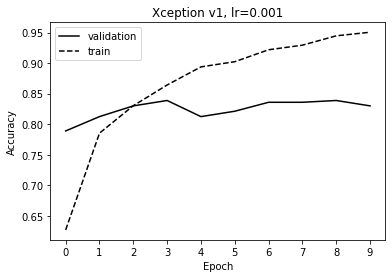

In [22]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [23]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']

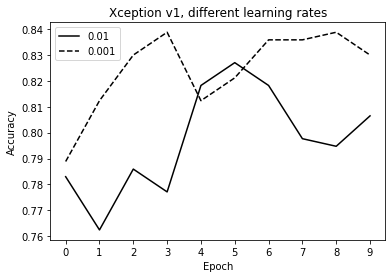

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

The best models:

* learning rate 0.01: 0.8270
* learning rate 0.001: 0.8299

To save the best model, we can use a callback. It'll monitor the accuracy, and if it's an improvement over the previous version, it'll save the model to disk

In [25]:
model = make_model(learning_rate=0.001)

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - 16s 149ms/step - loss: 1.1204 - accuracy: 0.6193 - val_loss: 0.7065 - val_accuracy: 0.7889


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
96/96 [==============================] - 14s 149ms/step - loss: 0.6256 - accuracy: 0.7904 - val_loss: 0.6526 - val_accuracy: 0.7918
Epoch 3/10
96/96 [==============================] - 14s 141ms/step - loss: 0.5105 - accuracy: 0.8312 - val_loss: 0.5938 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 15s 154ms/step - loss: 0.4288 - accuracy: 0.8703 - val_loss: 0.6086 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 14s 141ms/step - loss: 0.3766 - accuracy: 0.8804 - val_loss: 0.5578 - val_accuracy: 0.8211
Epoch 6/10
96/96 [==============================] - 14s 147ms/step - loss: 0.3257 - accuracy: 0.9051 - val_loss: 0.5587 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 14s 142ms/step - loss: 0.2948 - accuracy: 0.9179 - val_loss: 0.5433 - val_accuracy: 0.8270
Epoch 8/10
96/96 [==============================] - 15s 155ms/step - loss: 0.2562 - accuracy: 0.9351 - val_loss: 0.5487 - val_accuracy: 0.8270

Let's add one more layer - and a dropout between them

In [27]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [28]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 18s 160ms/step - loss: 0.9495 - accuracy: 0.6754 - val_loss: 0.6415 - val_accuracy: 0.7918
Epoch 2/30
96/96 [==============================] - 14s 151ms/step - loss: 0.5050 - accuracy: 0.8292 - val_loss: 0.6105 - val_accuracy: 0.7742
Epoch 3/30
96/96 [==============================] - 14s 146ms/step - loss: 0.3512 - accuracy: 0.8758 - val_loss: 0.5341 - val_accuracy: 0.8240
Epoch 4/30
96/96 [==============================] - 16s 165ms/step - loss: 0.2453 - accuracy: 0.9241 - val_loss: 0.5628 - val_accuracy: 0.8152
Epoch 5/30
96/96 [==============================] - 14s 147ms/step - loss: 0.1723 - accuracy: 0.9518 - val_loss: 0.6080 - val_accuracy: 0.8006
Epoch 6/30
96/96 [==============================] - 18s 184ms/step - loss: 0.1224 - accuracy: 0.9729 - val_loss: 0.5782 - val_accuracy: 0.8123
Epoch 7/30
96/96 [==============================] - 18s 183ms/step - loss: 0.0850 - accuracy: 0.9873 - val_loss: 0.5849 - val_accuracy: 0.8270

In [29]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 17s 156ms/step - loss: 1.0716 - accuracy: 0.6372 - val_loss: 0.7098 - val_accuracy: 0.7889
Epoch 2/30
96/96 [==============================] - 16s 162ms/step - loss: 0.6193 - accuracy: 0.7826 - val_loss: 0.6023 - val_accuracy: 0.7918
Epoch 3/30
96/96 [==============================] - 14s 143ms/step - loss: 0.4581 - accuracy: 0.8442 - val_loss: 0.5410 - val_accuracy: 0.8211
Epoch 4/30
96/96 [==============================] - 15s 152ms/step - loss: 0.3575 - accuracy: 0.8814 - val_loss: 0.5806 - val_accuracy: 0.8035
Epoch 5/30
96/96 [==============================] - 15s 161ms/step - loss: 0.2847 - accuracy: 0.9045 - val_loss: 0.5507 - val_accuracy: 0.7947
Epoch 6/30
96/96 [==============================] - 14s 145ms/step - loss: 0.2278 - accuracy: 0.9286 - val_loss: 0.5552 - val_accuracy: 0.8123
Epoch 7/30
96/96 [==============================] - 15s 156ms/step - loss: 0.1825 - accuracy: 0.9465 - val_loss: 0.5396 - val_accuracy: 0.8182

In [30]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 17s 156ms/step - loss: 1.3059 - accuracy: 0.5671 - val_loss: 0.7618 - val_accuracy: 0.7507
Epoch 2/30
96/96 [==============================] - 21s 215ms/step - loss: 0.8471 - accuracy: 0.7115 - val_loss: 0.6414 - val_accuracy: 0.7889
Epoch 3/30
96/96 [==============================] - 20s 211ms/step - loss: 0.6992 - accuracy: 0.7686 - val_loss: 0.6063 - val_accuracy: 0.7977
Epoch 4/30
96/96 [==============================] - 20s 205ms/step - loss: 0.6054 - accuracy: 0.7819 - val_loss: 0.6021 - val_accuracy: 0.8035
Epoch 5/30
96/96 [==============================] - 18s 184ms/step - loss: 0.5320 - accuracy: 0.8194 - val_loss: 0.5613 - val_accuracy: 0.8094
Epoch 6/30
96/96 [==============================] - 16s 161ms/step - loss: 0.4443 - accuracy: 0.8406 - val_loss: 0.5596 - val_accuracy: 0.8006
Epoch 7/30
96/96 [==============================] - 14s 146ms/step - loss: 0.4188 - accuracy: 0.8517 - val_loss: 0.5262 - val_accuracy: 0.8182

In [31]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']

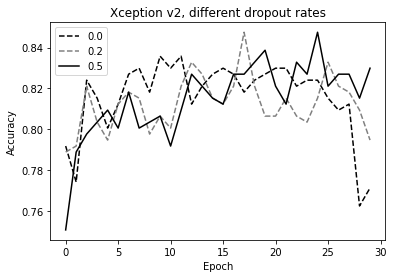

In [32]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')

plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

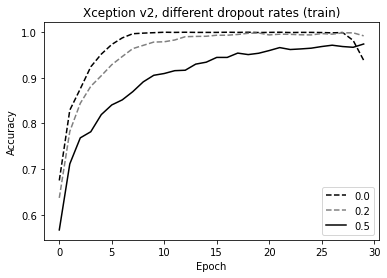

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')

plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

## Data augmentation

In [34]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "../input/clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [35]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "../input/clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [36]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
96/96 [==============================] - 31s 297ms/step - loss: 1.1287 - accuracy: 0.6154 - val_loss: 0.7393 - val_accuracy: 0.7478
Epoch 2/50
96/96 [==============================] - 29s 303ms/step - loss: 0.7346 - accuracy: 0.7552 - val_loss: 0.6713 - val_accuracy: 0.7889
Epoch 3/50
96/96 [==============================] - 30s 312ms/step - loss: 0.5960 - accuracy: 0.7976 - val_loss: 0.5795 - val_accuracy: 0.8211
Epoch 4/50
96/96 [==============================] - 30s 312ms/step - loss: 0.5375 - accuracy: 0.8178 - val_loss: 0.5716 - val_accuracy: 0.8035
Epoch 5/50
96/96 [==============================] - 30s 313ms/step - loss: 0.4618 - accuracy: 0.8360 - val_loss: 0.6189 - val_accuracy: 0.7830
Epoch 6/50
96/96 [==============================] - 30s 309ms/step - loss: 0.4089 - accuracy: 0.8592 - val_loss: 0.5806 - val_accuracy: 0.8123
Epoch 7/50
96/96 [==============================] - 30s 308ms/step - loss: 0.3786 - accuracy: 0.8716 - val_loss: 0.6073 - val_accuracy: 0.8035

In [37]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

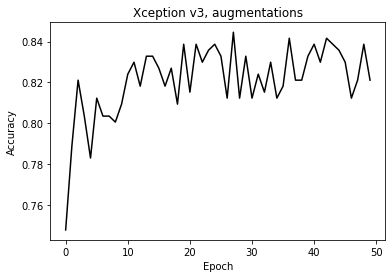

In [38]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

## Larger model

In [39]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [40]:
image_size = (299, 299)
batch_size = 32

In [41]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "../input/clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [42]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "../input/clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [43]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
96/96 [==============================] - 82s 827ms/step - loss: 0.8140 - accuracy: 0.7373 - val_loss: 0.4638 - val_accuracy: 0.8563
Epoch 2/20
96/96 [==============================] - 79s 824ms/step - loss: 0.4648 - accuracy: 0.8458 - val_loss: 0.4288 - val_accuracy: 0.8446
Epoch 3/20
96/96 [==============================] - 78s 812ms/step - loss: 0.3850 - accuracy: 0.8677 - val_loss: 0.3788 - val_accuracy: 0.8680
Epoch 4/20
96/96 [==============================] - 78s 808ms/step - loss: 0.3450 - accuracy: 0.8814 - val_loss: 0.4059 - val_accuracy: 0.8592
Epoch 5/20
96/96 [==============================] - 78s 814ms/step - loss: 0.3038 - accuracy: 0.8960 - val_loss: 0.4335 - val_accuracy: 0.8592
Epoch 6/20
96/96 [==============================] - 78s 815ms/step - loss: 0.2578 - accuracy: 0.9123 - val_loss: 0.4019 - val_accuracy: 0.8739
Epoch 7/20
96/96 [==============================] - 79s 822ms/step - loss: 0.2416 - accuracy: 0.9113 - val_loss: 0.3851 - val_accuracy: 0.8827

Let's test these models

In [44]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

## Big model

In [45]:
image_size = (299, 299)

In [46]:
#for load pretrained model
# model = keras.models.load_model('./xception_v4_large_07_0.883.h5')

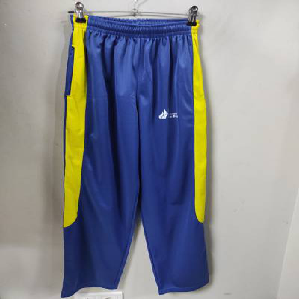

In [47]:
path = '../input/clothing-dataset-small/train/pants/03b5fa92-c65d-4b45-820b-967e85f41ee2.jpg'
img = load_img(path, target_size=(image_size))
img

In [48]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [49]:
pred = model.predict(X)
labels[pred[0].argmax()]

'pants'